<a href="https://colab.research.google.com/github/du-hr/MNIST-CNN/blob/Teresa/MiniProject_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MiniProject 3: Multi-label Classification of Image Data


> MiniProject 3 of COMP 551 (Fall 2020) at McGill University


> Authors (G17): Haoran Du (260776911), Robin Cho (260806783), Teresa Lee (260715070)





In [1]:
import numpy as np
import scipy as sci
import pandas as pd
import h5py
import torch
from google.colab import drive
# ignore the follwoing line if running locally
drive.mount('/content/drive')
# make path = './' if running locally
path = '/content/drive/My Drive/'

#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt


Mounted at /content/drive


## **1. Datasets**

### **1.1 Import Data**

<KeysViewHDF5 ['test_dataset', 'train_dataset', 'train_labels']>
(56000, 64, 64, 1)


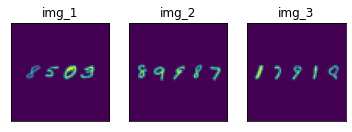

(56000, 5)
[[ 8  5  0  3 10]
 [ 8  9  9  8  7]
 [ 1  7  9  1  8]
 ...
 [ 4  4 10 10 10]
 [ 7  9  8 10 10]
 [ 6 10 10 10 10]]


In [2]:
# load the datasets
with h5py.File(path+'MNIST_synthetic.h5', 'r') as hdfid:
     print(hdfid.keys())
     test_images = hdfid['test_dataset'][()]
     train_images = hdfid['train_dataset'][()]
     train_labels = hdfid['train_labels'][()]

# display train_images properties
print(train_images.shape)
# print(train_iamges[10][30])

# plot first 3 images in train_images
images=[]
titles=[]
images.append(np.array(train_images[0], dtype='float').reshape(64,64))
titles.append("img_1")
images.append(np.array(train_images[1], dtype='float').reshape(64,64))
titles.append("img_2")
images.append(np.array(train_images[2], dtype='float').reshape(64,64))
titles.append("img_3")

for i in range(3):
    plt.subplot(1,3,i+1),plt.imshow(images[i])
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.show()

# display train_labels properties
print(train_labels.shape)
print(train_labels)

### **1.2 Data Preprocessing**

###**1.2.1 One Hot Encoding**

In [3]:
#First, perform OHE on training labels
from keras.utils import to_categorical

train_new_labels = to_categorical(train_labels)
Y_train = torch.from_numpy(train_new_labels) #save the oneHotEncoded labels as tensor

In [4]:
Y_train

tensor([[[0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.]],

        [[0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 0.,

In [5]:
Y_train.shape

torch.Size([56000, 5, 11])

### **1.2.2 Data Normalization**

In [8]:
# normalize to range 0-1 with typecast to float
def data_normalized(x):
  scaled_x = x.astype('float32') / 255.0
  return scaled_x

scaled_train_images = data_normalized(train_images)

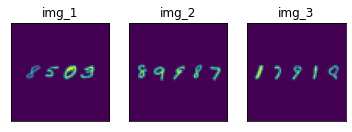

In [9]:
images_scaled=[]
titles_scaled=[]
images_scaled.append(np.array(scaled_train_images[0], dtype='float').reshape(64,64))
titles_scaled.append("img_1")
images_scaled.append(np.array(scaled_train_images[1], dtype='float').reshape(64,64))
titles_scaled.append("img_2")
images_scaled.append(np.array(scaled_train_images[2], dtype='float').reshape(64,64))
titles_scaled.append("img_3")

for i in range(3):
    plt.subplot(1,3,i+1),plt.imshow(images_scaled[i])
    plt.title(titles_scaled[i])
    plt.xticks([]),plt.yticks([])

plt.show()

In [47]:
X_train = torch.from_numpy(scaled_train_images)

###**1.2.3 Detecting the number of digits**

In [10]:
import cv2
threshold = 1 #Hyperparameter?
width = 12
height = 12

In [11]:
def findDigits(img):
  #Note that a normalized image does not work
  ret,thresh = cv2.threshold(img,threshold,255,0)
  contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  #print(len(contours))
  def getKey(item):
    return item[0]

  digitsLoc = []
  minArea = 15
  for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if w == 1 and h > 4:
      listTemp = [x, y, w, h]
      digitsLoc.append(listTemp)
    
    elif w * h > minArea:
      listTemp = [x, y, w, h]
      digitsLoc.append(listTemp)
  
  return sorted(digitsLoc, key = lambda x: x[0])

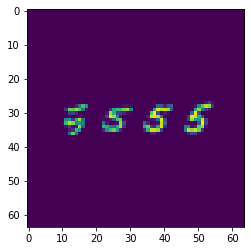

Case#:  264 Detected:  3  Expected:  4
Case#:  1530 Detected:  4  Expected:  5
Case#:  3344 Detected:  1  Expected:  2
Case#:  3709 Detected:  3  Expected:  4
Case#:  4142 Detected:  4  Expected:  5
Case#:  4155 Detected:  3  Expected:  4
Case#:  4757 Detected:  3  Expected:  4
Case#:  5245 Detected:  1  Expected:  2
Case#:  7023 Detected:  4  Expected:  5
Case#:  7348 Detected:  6  Expected:  5
Case#:  7491 Detected:  4  Expected:  5
Case#:  7958 Detected:  5  Expected:  4
Case#:  9140 Detected:  3  Expected:  4
Case#:  10223 Detected:  2  Expected:  3
Case#:  11408 Detected:  2  Expected:  3
Case#:  11739 Detected:  4  Expected:  5
Case#:  12629 Detected:  2  Expected:  3
Case#:  13291 Detected:  3  Expected:  4
Case#:  13551 Detected:  4  Expected:  5
Case#:  16801 Detected:  3  Expected:  4
Case#:  17768 Detected:  6  Expected:  5
Case#:  18127 Detected:  4  Expected:  5
Case#:  20220 Detected:  3  Expected:  4
Case#:  22505 Detected:  1  Expected:  2
Case#:  22884 Detected:  5  Ex

In [12]:
images_scaled=[]
images_scaled.append(np.array(train_images[4476], dtype='float').reshape(64,64))
sample = plt.imshow(images_scaled[0])
plt.show()

#x = findDigits(train_images[3282])
passed = 0
total = 0

for i in range(0, 56000):
  x = len(findDigits(train_images[i]))
  n = 0
  for c in train_labels[i]:
    if c != 10:
      n = n + 1
  
  if n == x:
    passed = passed + 1
  else:
    print("Case#: ",i, "Detected: " ,x, " Expected: ", n)
  total = total + 1

print(passed/total)

### **1.2.4 Class Distribution**


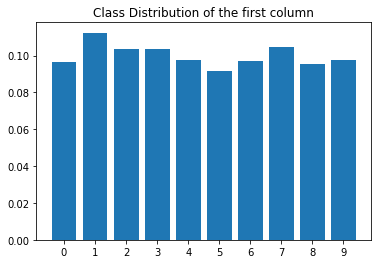

In [ ]:
unique_y1, counts_y1 = np.unique(train_labels[:, 0], return_counts=True)
plt.bar(unique_y1, counts_y1/sum(counts_y1))
plt.xticks(unique_y1, unique_y1)
plt.title(f"Class Distribution of the first column")
plt.show()

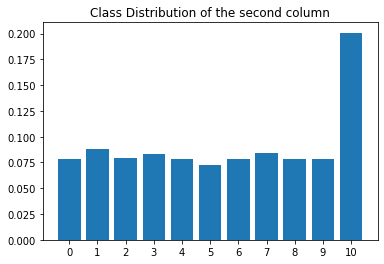

In [ ]:
unique_y2, counts_y2 = np.unique(train_labels[:, 1], return_counts=True)
plt.bar(unique_y2, counts_y2/sum(counts_y2))
plt.xticks(unique_y2, unique_y2)
plt.title(f"Class Distribution of the second column")
plt.show()

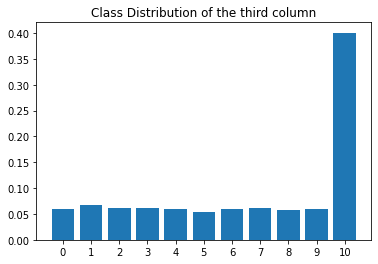

In [ ]:
unique_y3, counts_y3 = np.unique(train_labels[:, 2], return_counts=True)
plt.bar(unique_y3, counts_y3/sum(counts_y3))
plt.xticks(unique_y3, unique_y3)
plt.title(f"Class Distribution of the third column")
plt.show()

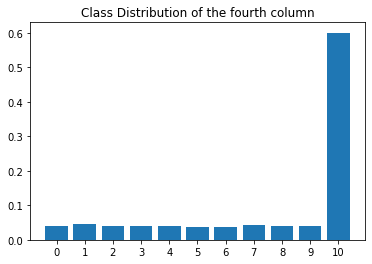

In [ ]:
unique_y4, counts_y4 = np.unique(train_labels[:, 3], return_counts=True)
plt.bar(unique_y4, counts_y4/sum(counts_y4))
plt.xticks(unique_y4, unique_y4)
plt.title(f"Class Distribution of the fourth column")
plt.show()

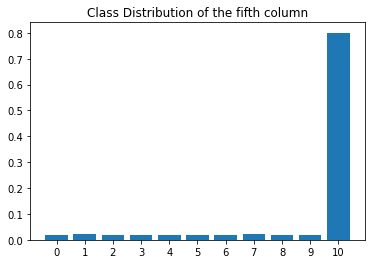

In [ ]:
unique_y5, counts_y5 = np.unique(train_labels[:, 4], return_counts=True)
plt.bar(unique_y5, counts_y5/sum(counts_y5))
plt.xticks(unique_y5, unique_y5)
plt.title(f"Class Distribution of the fifth column")
plt.show()

### **1.2.4 Upper bound and lower bound of the images**
Note: the name of the title is subject to change


In [280]:
def lowerBound(x):
  N = x.shape[1]
  D = x.shape[0]
  lowerBounds = [0]*D
  bound = x[0, 0]
  for i in list(range(0, D)):
    for j in list(range(0, N)):
      if torch.all(torch.eq(x[i, j], bound)):
        lowerBounds[i] = j + 1
      else:
        break
  return min(lowerBounds)
  
def upperBound(x):
  N = x.shape[1]
  D = x.shape[0]
  upperBounds = [64]*D
  bound = x[0, 0]
  for i in list(range(0, D)):
    for j in list(range(0, N)):
      if torch.all(torch.eq(x[i, 63-j], bound)):
        upperBounds[i] = 63-j
      else:
        break
  return max(upperBounds)

In [132]:
def leftBound(x):
  N = x.shape[2]
  D = x.shape[0]
  leftBounds = [0]*D
  bound = x[0, :, 0]
  for i in list(range(0, D)):
    for j in list(range(0, N)):
      if torch.all(torch.eq(x[i, :, j], bound)):
        leftBounds[i] = j + 1
      else:
        break
  return min(leftBounds)
  
def rightBound(x):
  N = x.shape[2]
  D = x.shape[0]
  rightBounds = [64]*D
  bound = x[0, :, 0]
  for i in list(range(0, D)):
    for j in list(range(0, N)):
      if torch.all(torch.eq(x[i, :, 63 - j], bound)):
        rightBounds[i] = 63 - j
      else:
        break
  return max(rightBounds)

In [281]:
l = leftBound(X_train)
r = rightBound(X_train)
u = upperBound(X_train)
l = lowerBound(X_train)

print("Left Bound: ",l, "Right Bound: " ,r, " Upper Bound: ", u, "Lower Bound: ", l)

Left Bound:  26 Right Bound:  62  Upper Bound:  38 Lower Bound:  26


### **1.2.5 Partitioning the data**


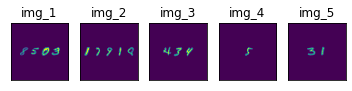

In [46]:
images=[]
titles=[]
images.append(np.array(train_images[0], dtype='float').reshape(64,64))
titles.append("img_1")
images.append(np.array(train_images[2], dtype='float').reshape(64,64))
titles.append("img_2")
images.append(np.array(train_images[5], dtype='float').reshape(64,64))
titles.append("img_3")
images.append(np.array(train_images[9], dtype='float').reshape(64,64))
titles.append("img_4")
images.append(np.array(train_images[26], dtype='float').reshape(64,64))
titles.append("img_5")

for i in range(5):
    plt.subplot(1,5,i+1),plt.imshow(images[i])
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

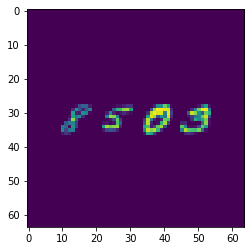

In [168]:
x_try = train_images[0]
x_try = np.float32(x_try).reshape(64, 64)
plt.imshow(x_try)

In [170]:
x_try.shape

(64, 64)

In [232]:
def leftBound2D_empty(x, initial_column):
  N = x.shape[1] #column
  leftBound = 0
  bound = torch.zeros(x[:, 0].shape)
  for i in list(range(initial_column, N)):
    if torch.all(torch.eq(x[:, i], bound)):
      leftBound = i + 1
    else:
      break
  return leftBound

In [233]:
def leftBound2D_with_number(x, initial_column):
  N = x.shape[1] #column
  leftBound = 0
  bound = torch.zeros(x[:, 0].shape)
  for i in list(range(initial_column, N)):
    if torch.all(torch.eq(x[:, i], bound)) == False:
      leftBound = i + 1
    else:
      break
  return leftBound

In [264]:
x_try2 = torch.from_numpy(x_try)
l1_1 = leftBound2D_empty(x_try2, 0)
l1_2 = leftBound2D_with_number(x_try2, l1_1)
l2_1 = leftBound2D_empty(x_try2, l1_2)
l2_2 = leftBound2D_with_number(x_try2, l2_1)
l3_1 = leftBound2D_empty(x_try2, l2_2)
l3_2 = leftBound2D_with_number(x_try2, l3_1)
l4_1 = leftBound2D_empty(x_try2, l3_2)
l4_2 = leftBound2D_with_number(x_try2, l4_1)

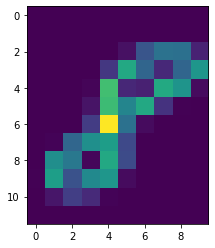

In [282]:
plt.imshow(x_try2[26:38 ,l1_1:l1_2])

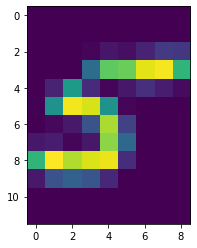

In [284]:
plt.imshow(x_try2[26:38 ,l2_1:l2_2])

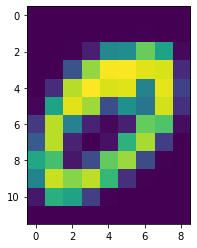

In [285]:
plt.imshow(x_try2[26:38 ,l3_1:l3_2])

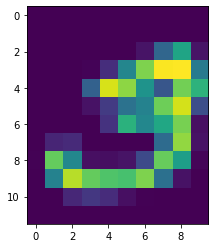

In [286]:
plt.imshow(x_try2[26:38 ,l4_1:l4_2])

In [297]:
l5_1 = leftBound2D_empty(x_try2, l4_2)
l5_2 = leftBound2D_with_number(x_try2, l5_1)
print(" l5_1: ", l5_1, "l5_2: ", l5_2) #think about how to handle this
'''
if(l == 64 && r == 0):
  the digit = torch.zeros((12, 12))
'''

 l5_1:  64 l5_2:  0


In [287]:
x_try2[26:38,l1_1:l1_2].shape

torch.Size([12, 10])

In [312]:
x_try21 = torch.zeros((12, 12))
x_try21[0:12, 0: x_try2[26:38,l1_1:l1_2].shape[1]] = x_try2[26:38,l1_1:l1_2]

In [300]:
x_try22 = torch.zeros((12, 12))
x_try22[0:12, 0: x_try2[26:38,l2_1:l2_2].shape[1]] = x_try2[26:38,l2_1:l2_2]

In [301]:
x_try23 = torch.zeros((12, 12))
x_try23[0:12, 0: x_try2[26:38,l3_1:l3_2].shape[1]] = x_try2[26:38,l3_1:l3_2]

In [302]:
x_try24 = torch.zeros((12, 12))
x_try24[0:12, 0: x_try2[26:38,l4_1:l4_2].shape[1]] = x_try2[26:38,l4_1:l4_2]

In [307]:
x_try25 = torch.zeros((12, 12))

In [309]:
x_try20 = torch.stack((x_try21, x_try22, x_try23, x_try24, x_try25))
x_try20.shape

torch.Size([5, 12, 12])

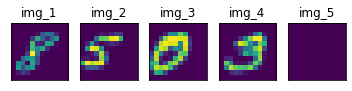

In [311]:
for i in range(5):
    plt.subplot(1,5,i+1),plt.imshow(x_try20[i, :, :])
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

In [308]:
#12*12 is our standard

#write a function that combine what I have done
#try on 5/3/2/1 digits

## **2. Neural Network Models**

In [ ]:
#classification
#subset data into groups

from sklearn.model_selection import KFold
cross_validation = KFold(n_splits=5)
#cross_validation.split(X, y=None, groups=None)

In [ ]:
'''
logistic: https://towardsdatascience.com/logistic-regression-on-mnist-with-pytorch-b048327f8d19
clustering: https://www.dlology.com/blog/how-to-do-unsupervised-clustering-with-keras/ 
'''

## **3. Performance**

## **4. Application to the Testing Images**